# 📊 Sentiment Analysis on Gojek App Reviews

This notebook presents a sentiment analysis project using user reviews of the **Gojek app**, obtained from [Kaggle](https://www.kaggle.com/datasets/dewanakretarta/gojek-playstore-reviews/data).
We explore and compare different approaches for text classification in Bahasa Indonesia, including:

* **Support Vector Machine (SVM) + TF-IDF**
* **SVM + Word Embedding**
* **IndoBERT (Pretrained BERT for Indonesian)**

The goal is to classify the reviews into **positive**, **neutral**, or **negative** sentiments, and evaluate model performance using standard classification metrics.

---

## IMPORT LIBRARY

In [ ]:
# !pip uninstall -y pandas numpy transformers sastrawi gensim emoji tqdm

# !pip install transformers sastrawi gensim emoji tqdm

In [7]:
!pip install pandas numpy --force-reinstall
!pip install transformers sastrawi gensim emoji tqdm datasets evaluate

  Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninsta

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 w

In [1]:
import pandas as pd
import numpy as np
import string

# NLP
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import emoji
import torch

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec

# Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import os
os.environ["WANDB_DISABLED"] = "true"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Stopwords
stop_factory = StopWordRemoverFactory()
stopwords = set(nltk_stopwords.words('indonesian') + nltk_stopwords.words('english'))
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Collection / Load Data

In [3]:
# read dataset
file_path = 'https://raw.githubusercontent.com/dwibagusd/sentiment-analysis-on-gojek-app-reviews/master/gojek_2025.csv'
df = pd.read_csv(file_path)

In [ ]:
# df = df.iloc[:500]

## Data Pre-Processing

In [ ]:
df['content']

,content
0,aku sudah 3th pakai gojek karena drivernya ram...
1,daftar meñjadi driver gojek-Go Partner seperti...
2,"baguss, murah² juga harganya"
3,menyenangkan
4,mantap sesuai dgn tujuan
...,...
21055,Awesome
21056,Walaupun harga mahal tetapi gampang makai apli...
21057,Kecewa dengan gojek. Layanan saya gopaylater t...
21058,Good job


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               21060 non-null  object
 1   score                 21060 non-null  int64 
 2   reviewCreatedVersion  21060 non-null  object
 3   at                    21060 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.3+ KB


### Cleaning Data

In [5]:
# Check Missing Values
df.isnull().sum()

,0
content,0
score,0
reviewCreatedVersion,0
at,0


In [6]:
# Check Data Duplicated
df.duplicated().sum()

0

#### Slang

In [7]:
# Load slang dictionary dari Excel (tanpa header)
slang_df = pd.read_excel('https://raw.githubusercontent.com/dwibagusd/sentiment-analysis-on-gojek-app-reviews/master/slang_indo1.xlsx', header=None)

In [8]:
slang_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3283 entries, 0 to 3282
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3283 non-null   object
 1   1       3275 non-null   object
dtypes: object(2)
memory usage: 51.4+ KB


In [9]:
# Tambahkan kolom sementara untuk menghitung jumlah kata
slang_df['jumlah_kata'] = slang_df[0].str.split().str.len()

slang_df.dropna(inplace=True)

# Urutkan sehingga dua kata (atau lebih) berada di atas
slang_df = slang_df.sort_values(by='jumlah_kata', ascending=False).reset_index(drop=True)

# Hapus kolom bantu jika tidak dibutuhkan
slang_df = slang_df.drop(columns='jumlah_kata')

# Hapus data duplikat
slang_df.duplicated(subset=[0], keep='first')

,0
0,False
1,False
2,False
3,True
4,False
...,...
3270,True
3271,True
3272,True
3273,True


In [10]:
slang_dict = dict(zip(slang_df[0], slang_df[1]))
slang_dict

{'the best transportation application in the world': 'aplikasi transportasi terbaik di dunia',
 'good driverpolite and clean': 'pengemudi yang baik',
 'is the best': 'terbaik',
 'tingkat kan': 'tingkatkan',
 'on time': 'tepat waktu',
 'go jek': 'gojek',
 'go ride': 'goride',
 'memuas kan': 'memuaskan',
 'sat set': 'cepat',
 'top markotop': 'mantap',
 'hatur nuhun': 'terima kasih',
 'service lah': 'servis',
 'truly satisfied': 'benar-benar puas',
 'log out': 'keluar',
 'good job': 'pekerjaan yang bagus',
 'safety comfot': 'kenyamanan keamanan',
 'se pihak': 'sepihak',
 'muda hn': 'mudah',
 'pokok e': 'pokoknya ',
 'is the': 'adalah',
 'go send': 'gosend',
 'jooozzzz mantaaaabbb': 'sangat bagus',
 'bulak balik': 'balik',
 'go car': 'gocar',
 'mntp': 'mantap ',
 'mndgr': 'mendengar ',
 'mndi': 'mandi ',
 'mnding': 'lebih baik',
 'mndptkn': 'mendapatkan ',
 'mng': 'menang ',
 'mnrt': 'menurut ',
 'mnsempurnakan': ' ',
 'mnt': 'minta ',
 'mnta': 'minta ',
 'ndax': 'tidak',
 'ngak': 'tidak '

In [11]:
# Fungsi normalisasi slang
def normalize_slang(tokens):
    # Pastikan semua elemen dalam tokens adalah string sebelum lookup
    return [str(slang_dict.get(str(word), str(word))) for word in tokens]

In [12]:
# Tambahan kata-kata tidak penting yang umum dalam bahasa informal
custom_stopwords = {
    'nya', 'sih', 'dong', 'deh', 'kok', 'nih', 'yah', 'kan', 'pun', 'lagi',
    'aja', 'in', 'di', 'ke', 'la', 'ha', 'eh', 'ya', 'oh', 'lho', 'loh'
}
stopwords.update(custom_stopwords)

#### Emoji

In [13]:
# # Buat Kamus Emoji Bahasa Indonesia
# emoji_to_text_id = {
#     "😀": " senyum ",
#     "😢": " sedih ",
#     "😂": " tertawa ",
#     "😍": " cinta ",
#     "😡": " marah ",
#     "😱": " takut ",
#     "🤔": " pikir ",
#     "👍": " bagus ",
#     "👎": " buruk ",
#     "😭": " nangis ",
#     "😊": " senyum ",
#     "😎": " keren ",
#     "🙄": " jengah ",
#     "😴": " ngantuk ",
#     "😅": " lega "
# }

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emotikon wajah
        u"\U0001F300-\U0001F5FF"  # simbol & pictograf
        u"\U0001F680-\U0001F6FF"  # transportasi & simbol
        u"\U0001F1E0-\U0001F1FF"  # bendera
        u"\U00002500-\U00002BEF"  # simbol cina
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # variasi selektor
        u"\u3030"
        "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


In [ ]:
# # Fungsi untuk Ganti Emoji dengan Kata Indonesia
# def replace_emoji_with_text_id(text):
#     return ''.join(emoji_to_text_id.get(char, char) for char in text)

#### preprocess v1

In [14]:
def preprocess1(text):
    text = text.lower()
    text = remove_emoji(text)                      # hapus emoji
    # text = replace_emoji_with_text_id(text)           # ubah emoji ke kata ID
    text = re.sub(r'http\S+', '', text)               # hapus link
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)          # hapus angka dan tanda baca
    text = re.sub(r'\s+', ' ', text).strip()          # hapus spasi ganda

    tokens = text.split()
    tokens = normalize_slang(tokens)                  # normalisasi slang
    # Filter: hapus kata ≤ 2 huruf dan stopwords
    tokens = [word for word in tokens if len(word) > 2 and word not in stopwords]

    cleaned = ' '.join(tokens)
    return cleaned

In [15]:
df['clean_text_v1'] = df['content'].apply(preprocess1)
# df['clean_text_v4'] = texts = [preprocess(t) for t in tqdm(texts)]

In [16]:
df[['content','clean_text_v1']].head(2)

,content,clean_text_v1
0,aku sudah 3th pakai gojek karena drivernya ram...,pakai gojek pengemudi ramah sopan mengendarain...
1,daftar meñjadi driver gojek-Go Partner seperti...,daftar pengemudi gojek partner daftar calon te...


#### preprocess v2

In [17]:
def preprocess2(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # hapus link
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # hapus angka dan tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi ganda

    tokens = word_tokenize(text)
    tokens = normalize_slang(tokens)
    tokens = [word for word in tokens if word not in stopwords and len(word) > 2]
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens  # kembalikan list token

In [18]:
df['clean_text_v2'] = df['content'].apply(preprocess2)
# df['clean_text_v3'] = texts = [preprocess(t) for t in tqdm(texts)]

In [19]:
df[['content','clean_text_v1','clean_text_v2']].head(2)

,content,clean_text_v1,clean_text_v2
0,aku sudah 3th pakai gojek karena drivernya ram...,pakai gojek pengemudi ramah sopan mengendarain...,"[pakai, gojek, kemudi, ramah, sopan, kendara, ..."
1,daftar meñjadi driver gojek-Go Partner seperti...,daftar pengemudi gojek partner daftar calon te...,"[daftar, mejadi, kemudi, gojek go, partner, da..."


## Exploratory Data Analysis

### Labelling

##### Using BERT

percobaan 1

In [ ]:
# pretrained = "Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis"
# model = AutoModelForSequenceClassification.from_pretrained(pretrained)
# tokenizer = AutoTokenizer.from_pretrained(pretrained)
# sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# # Map labels to human-readable format
# # label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}
# label_index = {
#     'Positive': 'positive',
#     'Negative': 'negative',
#     'Neutral': 'neutral'
# }
# # Apply sentiment analysis and store the result in a new column 'Sentiment'
# df['Sentiment1'] = df['clean_text_v1'].apply(lambda review: label_index[sentiment_analysis(review)[0]['label']])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cpu


KeyboardInterrupt: 

percobaan 2

In [ ]:
# pretrained = "mdhugol/indonesia-bert-sentiment-classification"
# model = AutoModelForSequenceClassification.from_pretrained(pretrained)
# tokenizer = AutoTokenizer.from_pretrained(pretrained)
# sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# # Map labels to human-readable format
# label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

# # Apply sentiment analysis and store the result in a new column 'Sentiment'
# df['Sentiment2'] = df['clean_text_v1'].apply(lambda review: label_index[sentiment_analysis(review)[0]['label']])

##### Using score

In [20]:
# Labeling using score
def map_score_to_sentiment(score):
  if score == 1:
    return 'negative'
  elif score in [2, 3]:
    return 'neutral'
  elif score in [4, 5]:
    return 'positive'
  else:
    return None # Handle cases with scores outside 1-5 if necessary

df['Sentiment1'] = df['score'].apply(map_score_to_sentiment)

#### Manual Labelling

In [21]:
# read dataset
file_path_1rb = 'https://raw.githubusercontent.com/dwibagusd/sentiment-analysis-on-gojek-app-reviews/master/gojek_2025_1rb.xlsx'
df_1rb = pd.read_excel(file_path_1rb)
df_1rb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   clean_text  1013 non-null   object 
 1   label       1013 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.8+ KB


In [22]:
df_1rb['label'] = df_1rb['label'].map({0.0: 'positive', 1.0: 'neutral', 2.0: 'negative'})

In [23]:
df_1rb.dropna(inplace=True)
df_1rb.rename(columns={'label': 'Sentiment2'}, inplace=True)
df_1rb.reset_index(drop=True, inplace=True)

In [ ]:
df_1rb.head(2)

,clean_text,Sentiment2
0,aku th pakai gojek drivernya ramah sopan menge...,positive
1,daftar mejadi driver gojekgo partner daftar ca...,neutral


In [24]:
# Gabungkan kolom 'Sentiment4' dari df_1rb ke df berdasarkan indeks
df = df.merge(df_1rb[['Sentiment2']], left_index=True, right_index=True, how='left')

# Tampilkan informasi dataframe setelah penggabungan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               21060 non-null  object
 1   score                 21060 non-null  int64 
 2   reviewCreatedVersion  21060 non-null  object
 3   at                    21060 non-null  object
 4   clean_text_v1         21060 non-null  object
 5   clean_text_v2         21060 non-null  object
 6   Sentiment1            21060 non-null  object
 7   Sentiment2            1013 non-null   object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


#### Results Labelling

In [25]:
df[['content', 'clean_text_v1','clean_text_v2', 'Sentiment1', 'Sentiment2', 'score']].head(25)

,content,clean_text_v1,clean_text_v2,Sentiment1,Sentiment2,score
0,aku sudah 3th pakai gojek karena drivernya ram...,pakai gojek pengemudi ramah sopan mengendarain...,"[pakai, gojek, kemudi, ramah, sopan, kendara, ...",positive,positive,5
1,daftar meñjadi driver gojek-Go Partner seperti...,daftar pengemudi gojek partner daftar calon te...,"[daftar, mejadi, kemudi, gojek go, partner, da...",neutral,neutral,2
2,"baguss, murah² juga harganya",bagus murah harga,"[bagus, murah, harga]",positive,positive,5
3,menyenangkan,menyenangkan,[senang],positive,positive,5
4,mantap sesuai dgn tujuan,mantap sesuai dengan tujuan,"[mantap, sesuai, dengan, tuju]",positive,positive,5
5,"Serius admin, jangan pernah mau merger ama gra...",serius admin gabung sama grab percaya sama s...,"[serius, admin, gabung, sama, grab, percaya, s...",neutral,neutral,2
6,my favorite app,favorit aplikasi,"[favorit, aplikasi]",positive,positive,5
7,"knpa setiap mau pesan slalu muncul kya gni ""be...",kenapa pesan selalu muncul begini layanan d...,"[kenapa, pesan, selalu, muncul, begini, layan,...",neutral,neutral,3
8,pertama pake go send sudah kecewa..SG udh byr ...,pakai send kecewa sudah bayar barang bayar ...,"[pakai, send, kecewa, sudah, bayar, barang, ba...",negative,negative,1
9,mantap 👍👍👍,mantap,[mantap],positive,positive,5


### Distribution of Sentiment

In [31]:
df.groupby('Sentiment1')['Sentiment1'].count()

,Sentiment1
Sentiment1,
negative,218
neutral,54
positive,741


In [32]:
df.groupby('Sentiment2')['Sentiment2'].count()

,Sentiment2
Sentiment2,
negative,180
neutral,218
positive,615


<ipython-input-33-7fc80ac110d7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment1', data=df, order=df['Sentiment1'].value_counts().index, palette='viridis')


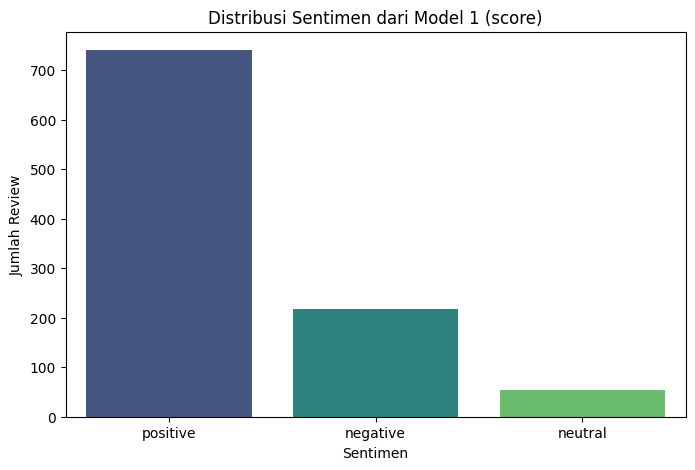

<ipython-input-33-7fc80ac110d7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment2', data=df, order=df['Sentiment2'].value_counts().index, palette='viridis')


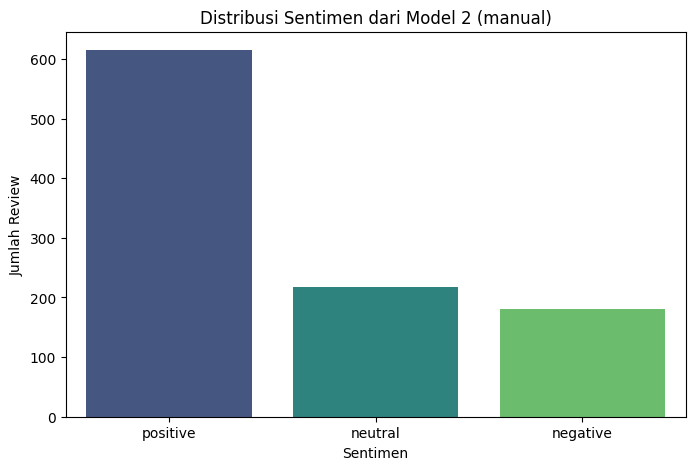

In [33]:
# Visualisasi distribusi Sentimen 1
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment1', data=df, order=df['Sentiment1'].value_counts().index, palette='viridis')
plt.title('Distribusi Sentimen dari Model 1 (score)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

# Visualisasi distribusi Sentimen 2
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment2', data=df, order=df['Sentiment2'].value_counts().index, palette='viridis')
plt.title('Distribusi Sentimen dari Model 2 (manual)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

### Persentase of Sentiment

In [ ]:
# Hitung jumlah sentimen untuk setiap kategori
sentiment_counts = df['Sentiment1'].value_counts()

# Buat diagram pie
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribusi Persentase Sentimen 1 (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Sentiment2
sentiment_counts2 = df['Sentiment2'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts2, labels=sentiment_counts2.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribusi Persentase Sentimen 2 (Pie Chart)')
plt.axis('equal')
plt.show()

### Wordcloud

In [ ]:
# !pip install wordcloud

# Gabungkan semua teks dari kolom 'clean_text_v1'
all_text1 = ' '.join(df['clean_text_v1'])

# Buat objek WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords, # Gunakan stopwords yang sudah didefinisikan
                min_font_size = 10).generate(all_text1)

# Tampilkan WordCloud
print("Word Cloud of Cleaned Text v1")
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.title('Word Cloud of Cleaned Text v1')
plt.show()

# Check Point :)

In [26]:
df = pd.read_excel('https://raw.githubusercontent.com/dwibagusd/sentiment-analysis-on-gojek-app-reviews/master/gojek_2025_clean.xlsx')
# df = pd.read_excel('clean_text_1rb.xlsx')
# df.to_excel('gojek_2025_clean.xlsx', index=False)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013 entries, 0 to 1012
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               1013 non-null   object
 1   score                 1013 non-null   int64 
 2   reviewCreatedVersion  1013 non-null   object
 3   at                    1013 non-null   object
 4   clean_text_v1         1013 non-null   object
 5   clean_text_v2         1013 non-null   object
 6   Sentiment1            1013 non-null   object
 7   Sentiment2            1013 non-null   object
dtypes: int64(1), object(7)
memory usage: 71.2+ KB


In [28]:
df.dropna(inplace=True)

In [30]:
# Menampilkan baris di mana 'Sentiment1' berbeda dengan 'Sentiment2'
different_sentiments = df[df['Sentiment1'] != df['Sentiment2']]
print("Rows with different sentiments in 'Sentiment1' and 'Sentiment2':")
different_sentiments[['content', 'clean_text_v1', 'clean_text_v2', 'Sentiment1', 'Sentiment2']].head(50)

Rows with different sentiments in 'Sentiment1' and 'Sentiment2':


,content,clean_text_v1,clean_text_v2,Sentiment1,Sentiment2
11,promo nya di tambahi 5 star,promo bintang,"[promo, bintang]",positive,neutral
18,service ok lah,servis oke,"[servis, oke]",positive,neutral
19,"saya sudah lama menggunakan gojek, awalnya lan...",gojek lancar pesanan jam makanannya menit alas...,"[gojek, lancar, pesan, jam, makan, menit, alas...",positive,negative
24,saya isi saldo 30.000 laporan nya ada saldonya...,isi saldo laporan saldonya masuk,"[isi, saldo, lapor, saldo, masuk]",neutral,negative
27,isi saldo udah ada riwayat nya tapi saldo ga n...,isi saldo riwayat saldo tambah,"[isi, saldo, riwayat, saldo, tambah]",negative,neutral
28,"tolong dong, ini ngisi saldo udah berhasil di ...",tolong mengisi saldo berhasil transfer notifik...,"[tolong, isi, saldo, hasil, transfer, notifika...",negative,neutral
30,ini gojek kenapa y? saya topup 50rb tp kenapa ...,gojek iya topup ribu masuk notif gojek sudah ...,"[gojek, iya, topup, ribu, masuk, notif, gojek,...",neutral,negative
31,"dear gojek, tolong dong saya sudah TF TAPI HAN...",gojek tolong transfer notip saja yang masuk...,"[gojek, tolong, transfer, notip, saja, yang, m...",neutral,negative
37,kenapa saya top up gopay kadang masuk kadang e...,gopay kadang masuk kadang tidak update log te...,"[gopay, kadang, masuk, kadang, tidak, update, ...",negative,neutral
43,Alhamdulillah,alhamdulillah,[alhamdulillah],positive,neutral


## Data Split

In [36]:
df_copy = df

<ipython-input-18-f189788f4b86>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment2', data=df_copy, order=df_copy['Sentiment2'].value_counts().index, palette='viridis')


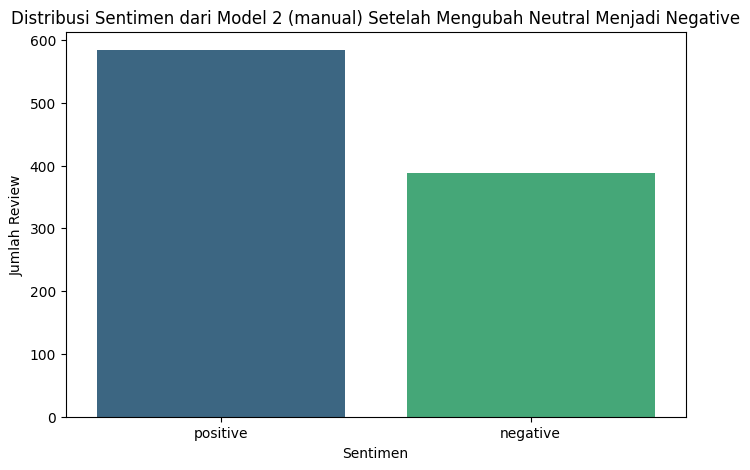

In [ ]:
# df_copy['Sentiment2'] = df_copy['Sentiment2'].replace('neutral', 'negative')
# df_copy.groupby('Sentiment2')['Sentiment2'].count()

# # Visualisasi distribusi Sentimen 2 setelah diubah
# plt.figure(figsize=(8, 5))
# sns.countplot(x='Sentiment2', data=df_copy, order=df_copy['Sentiment2'].value_counts().index, palette='viridis')
# plt.title('Distribusi Sentimen dari Model 2 (manual) Setelah Mengubah Neutral Menjadi Negative')
# plt.xlabel('Sentimen')
# plt.ylabel('Jumlah Review')
# plt.show()

In [39]:
X = df_copy['clean_text_v1'] #
y = df_copy['Sentiment1'] # Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Encode label ke numerik
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)


## FEATURE EXTRACTION

### TF-IDF

In [78]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=3000, min_df=3)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

TypeError: TfidfVectorizer.__init__() got an unexpected keyword argument 'alpha'

## Modelling

### SVM

#### TF-IDF

In [108]:
# Encode label ke numerik
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Pipeline: TF-IDF + LinearSVC ---
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# --- Grid Search Parameter ---
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.85, 0.9, 1.0],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': ['balanced', None]
}

# --- Stratified K-Fold Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid SearchCV ---
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',  # atau 'accuracy', 'f1_weighted' sesuai kebutuhan
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# --- Fit model ---
grid.fit(X, y_encoded)

# --- Best result ---
print("Best Score (CV):", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# --- Evaluasi akhir di seluruh data (atau bisa pakai test set terpisah) ---
y_pred = grid.best_estimator_.predict(X)
print("\nFinal Evaluation on Full Data:")
print(classification_report(y_encoded, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Score (CV): 0.8460225332878115
Best Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}

Final Evaluation on Full Data:
              precision    recall  f1-score   support

    negative       0.97      0.97      0.97       218
     neutral       0.96      0.94      0.95        54
    positive       0.99      0.99      0.99       741

    accuracy                           0.98      1013
   macro avg       0.97      0.97      0.97      1013
weighted avg       0.98      0.98      0.98      1013



#### Word2vec

In [79]:
sentences = df_copy['clean_text_v2'].tolist()

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

# Fungsi untuk membuat representasi vektor dokumen
def document_vector(word2vec_model, doc):
    # Filter out words not in the vocabulary
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    # Return the mean of the word vectors
    return np.mean(word2vec_model.wv[doc], axis=0)

# Buat representasi vektor untuk seluruh dataset
X_w2v = np.vstack([document_vector(w2v_model, doc) for doc in df_copy['clean_text_v2']])

# Handle potential NaNs if some documents were empty after filtering
X_w2v[np.isnan(X_w2v)] = 0


In [80]:
# Encode label ke numerik
le = LabelEncoder()
y_encoded = le.fit_transform(y) # Gunakan y yang sudah didefinisikan

# Split data yang sudah dalam bentuk vektor
X_train_w2v, X_test_w2v, y_train_encoded, y_test_encoded = train_test_split(
    X_w2v, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# --- Pipeline: Word2Vec (representasi vektor) + LinearSVC ---
pipeline_w2v = Pipeline([
    ('clf', LinearSVC())
])

# --- Grid Search Parameter ---
param_grid_w2v = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__class_weight': ['balanced', None]
}

# --- Stratified K-Fold Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid SearchCV ---
grid_w2v = GridSearchCV(
    estimator=pipeline_w2v,
    param_grid=param_grid_w2v,
    scoring='f1_macro',  # atau 'accuracy', 'f1_weighted' sesuai kebutuhan
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# --- Fit model ---
grid_w2v.fit(X_train_w2v, y_train_encoded)

# --- Best result ---
print("Best Score (CV):", grid_w2v.best_score_)
print("Best Parameters:", grid_w2v.best_params_)

# --- Evaluasi pada Test Set ---
y_pred_w2v = grid_w2v.best_estimator_.predict(X_test_w2v)
print("\nEvaluation on Test Set:")
from sklearn.metrics import classification_report
print(classification_report(y_test_encoded, y_pred_w2v, target_names=le.classes_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score (CV): 0.5173418686137519
Best Parameters: {'clf__C': 100, 'clf__class_weight': 'balanced'}

Evaluation on Test Set:
              precision    recall  f1-score   support

    negative       0.61      0.77      0.68        44
     neutral       0.00      0.00      0.00        11
    positive       0.91      0.84      0.88       148

    accuracy                           0.78       203
   macro avg       0.51      0.54      0.52       203
weighted avg       0.80      0.78      0.79       203



In [81]:
# prompt: ubah code sebelumnya tambah smote

from imblearn.over_sampling import SMOTE

# Pisahkan data untuk SMOTE (hanya data training)
X_train_tfidf_smote = X_train_tfidf.copy()
y_train_encoded_smote = y_train_encoded.copy() # Gunakan y_train_encoded dari bagian Word2Vec

# Inisialisasi SMOTE
smote = SMOTE(random_state=42, k_neighbors=2) # k_neighbors bisa disesuaikan

# --- Terapkan SMOTE pada data training Word2Vec ---
# Gunakan X_train_w2v dan y_train_encoded yang sudah didefinisikan sebelumnya
X_train_w2v_resampled, y_train_encoded_resampled_w2v = smote.fit_resample(X_train_w2v, y_train_encoded)

print("\nShape before SMOTE (Word2Vec):", X_train_w2v.shape, y_train_encoded.shape)
print("Shape after SMOTE (Word2Vec):", X_train_w2v_resampled.shape, y_train_encoded_resampled_w2v.shape)


# --- Pipeline: Word2Vec (representasi vektor) + SMOTE + LinearSVC ---
pipeline_w2v_smote = Pipeline([
    ('clf', LinearSVC(class_weight='balanced')) # SMOTE dilakukan di luar pipeline
])

# --- Grid Search Parameter ---
param_grid_w2v_smote = {
    'clf__C': [0.1, 1, 10, 100]
    # 'clf__class_weight': ['balanced', None] # class_weight mungkin tidak perlu jika SMOTE sudah dilakukan
}

# --- Stratified K-Fold Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid SearchCV ---
grid_w2v_smote = GridSearchCV(
    estimator=pipeline_w2v_smote,
    param_grid=param_grid_w2v_smote,
    scoring='f1_macro',  # atau 'accuracy', 'f1_weighted' sesuai kebutuhan
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# --- Fit model menggunakan data Word2Vec yang sudah di-SMOTE ---
grid_w2v_smote.fit(X_train_w2v_resampled, y_train_encoded_resampled_w2v)

# --- Best result ---
print("\n--- Word2Vec + SMOTE + LinearSVC ---")
print("Best Score (CV):", grid_w2v_smote.best_score_)
print("Best Parameters:", grid_w2v_smote.best_params_)

# --- Evaluasi pada Test Set ---
y_pred_w2v_smote = grid_w2v_smote.best_estimator_.predict(X_test_w2v)
print("\nEvaluation on Test Set:")
print(classification_report(y_test_encoded, y_pred_w2v_smote, target_names=le.classes_))



Shape before SMOTE (Word2Vec): (810, 100) (810,)
Shape after SMOTE (Word2Vec): (1779, 100) (1779,)
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Word2Vec + SMOTE + LinearSVC ---
Best Score (CV): 0.7830439543107943
Best Parameters: {'clf__C': 100}

Evaluation on Test Set:
              precision    recall  f1-score   support

    negative       0.47      0.59      0.53        44
     neutral       0.04      0.09      0.06        11
    positive       0.93      0.78      0.85       148

    accuracy                           0.70       203
   macro avg       0.48      0.49      0.48       203
weighted avg       0.79      0.70      0.74       203



### Naive Bayes

#### TF-IDF

In [75]:
X = df_copy['clean_text_v1'] #
y = df_copy['Sentiment1'] # Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Pipeline: TF-IDF + Multinomial Naive Bayes ---
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', ComplementNB())
])

# --- Grid Search Parameter ---
param_grid_nb = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.85, 0.9, 1.0],
    'clf__alpha': [0.1, 0.5, 1.0] # Smoothing parameter
}

# --- Stratified K-Fold Cross Validation ---
cv_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid SearchCV ---
grid_nb = GridSearchCV(
    estimator=pipeline_nb,
    param_grid=param_grid_nb,
    # scoring='recall',
    cv=cv_nb,
    verbose=2,
    n_jobs=-1
)

# --- Encode label ke numerik (jika belum dilakukan) ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Fit model ---
grid_nb.fit(X, y_encoded)

# --- Best result ---
print("Best Score (CV) for Naive Bayes:", grid_nb.best_score_)
print("Best Parameters for Naive Bayes:", grid_nb.best_params_)

# --- Evaluasi akhir di seluruh data (atau bisa pakai test set terpisah) ---
y_pred_nb = grid_nb.best_estimator_.predict(X)
print("\nFinal Evaluation on Full Data (Naive Bayes + TF-IDF):")
print(classification_report(y_encoded, y_pred_nb, target_names=le.classes_))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Score (CV) for Naive Bayes: 0.7907623274642734
Best Parameters for Naive Bayes: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}

Final Evaluation on Full Data (Naive Bayes + TF-IDF):
              precision    recall  f1-score   support

    negative       0.83      0.98      0.89       218
     neutral       1.00      0.93      0.96        54
    positive       0.99      0.94      0.96       741

    accuracy                           0.95      1013
   macro avg       0.94      0.95      0.94      1013
weighted avg       0.95      0.95      0.95      1013



#### Word2vec

In [84]:
# prompt: lakukan word2vec dengan naive bayes

from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.pipeline import Pipeline # Import Pipeline if not already imported
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Import these if not already imported
from sklearn.metrics import classification_report # Import this if not already imported
import numpy as np # Import numpy if not already imported

# --- Pipeline: Word2Vec (representasi vektor) + Naive Bayes ---
# Naive Bayes like GaussianNB is more suitable for data that can be negative.
# We will use GaussianNB for Word2Vec.

pipeline_nb_w2v = Pipeline([
    ('clf', GaussianNB()) # Changed to GaussianNB
])

# --- Grid Search Parameter ---
# GaussianNB typically does not have a 'alpha' parameter like ComplementNB/MultinomialNB.
# You could potentially tune parameters if GaussianNB has any, but often the default works well.
# If you want to tune, check the GaussianNB documentation for available parameters.
param_grid_nb_w2v = {
    # 'clf__parameter_name': [list_of_values] # Add parameters here if needed
}

# --- Stratified K-Fold Cross Validation ---
# Gunakan data split Word2Vec: X_w2v dan y_encoded
cv_nb_w2v = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid SearchCV ---
grid_nb_w2v = GridSearchCV(
    estimator=pipeline_nb_w2v,
    param_grid=param_grid_nb_w2v,
    scoring='f1_macro',  # atau 'accuracy', 'f1_weighted' sesuai kebutuhan
    cv=cv_nb_w2v,
    verbose=2,
    n_jobs=-1
)

# --- Fit model menggunakan seluruh data Word2Vec ---
grid_nb_w2v.fit(X_w2v, y_encoded)

# --- Best result ---
print("\n--- Naive Bayes (GaussianNB) + Word2Vec ---")
print("Best Score (CV):", grid_nb_w2v.best_score_)
print("Best Parameters:", grid_nb_w2v.best_params_)

# --- Evaluasi pada Test Set ---
y_pred_nb_w2v = grid_nb_w2v.best_estimator_.predict(X_test_w2v)
print("\nEvaluation on Test Set (Naive Bayes (GaussianNB) + Word2Vec):")
print(classification_report(y_test_encoded, y_pred_nb_w2v, target_names=le.classes_))

# --- Coba Naive Bayes (GaussianNB) + Word2Vec dengan SMOTE (pada data training) ---
# Gunakan data training Word2Vec yang sudah di-SMOTE: X_train_w2v_resampled, y_train_encoded_resampled_w2v

pipeline_nb_w2v_smote = Pipeline([
    ('clf', GaussianNB()) # Changed to GaussianNB
])

# GaussianNB doesn't have 'alpha'. Remove or replace with GaussianNB parameters if tuning.
param_grid_nb_w2v_smote = {
    # 'clf__parameter_name': [list_of_values] # Add parameters here if needed for GaussianNB
}


# Fit model Naive Bayes (GaussianNB) menggunakan data Word2Vec yang sudah di-SMOTE
# If param_grid_nb_w2v_smote is empty, you can fit directly without GridSearchCV
if param_grid_nb_w2v_smote:
    grid_nb_w2v_smote = GridSearchCV(
        estimator=pipeline_nb_w2v_smote,
        param_grid=param_grid_nb_w2v_smote,
        scoring='f1_macro',
        cv=cv_nb_w2v, # Can still use CV even if SMOTE is outside, evaluate on test set afterwards
        verbose=2,
        n_jobs=-1
    )
    grid_nb_w2v_smote.fit(X_train_w2v_resampled, y_train_encoded_resampled_w2v)
    nb_w2v_smote_model = grid_nb_w2v_smote.best_estimator_
    print("\n--- Naive Bayes (GaussianNB) + Word2Vec + SMOTE (GridSearchCV) ---")
    print("Best Score (CV):", grid_nb_w2v_smote.best_score_)
    print("Best Parameters:", grid_nb_w2v_smote.best_params_)
else:
    nb_w2v_smote_model = GaussianNB()
    nb_w2v_smote_model.fit(X_train_w2v_resampled, y_train_encoded_resampled_w2v)
    print("\n--- Naive Bayes (GaussianNB) + Word2Vec + SMOTE (Direct Fit) ---")


# Evaluasi pada Test Set
y_pred_nb_w2v_smote = nb_w2v_smote_model.predict(X_test_w2v)

print("\nEvaluation on Test Set:")
print(classification_report(y_test_encoded, y_pred_nb_w2v_smote, target_names=le.classes_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

--- Naive Bayes (GaussianNB) + Word2Vec ---
Best Score (CV): 0.4420018197279413
Best Parameters: {}

Evaluation on Test Set (Naive Bayes (GaussianNB) + Word2Vec):
              precision    recall  f1-score   support

    negative       0.44      0.80      0.57        44
     neutral       0.12      0.18      0.14        11
    positive       0.94      0.68      0.79       148

    accuracy                           0.68       203
   macro avg       0.50      0.55      0.50       203
weighted avg       0.79      0.68      0.71       203


--- Naive Bayes (GaussianNB) + Word2Vec + SMOTE (Direct Fit) ---

Evaluation on Test Set:
              precision    recall  f1-score   support

    negative       0.49      0.59      0.54        44
     neutral       0.12      0.27      0.16        11
    positive       0.90      0.76      0.82       148

    accuracy                           0.69       203
   macro avg       0.50      0.54

### IndoBERT

In [85]:
!pip install --upgrade transformers

In [87]:
from datasets import Dataset, load_metric
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report

# Assuming df_copy, le, and the necessary data splits (X, y, X_train, X_test, y_train, y_test) are already defined
X = df_copy['clean_text_v1'] #
y = df_copy['Sentiment1'] # Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Encode labels for Hugging Face format
le = LabelEncoder() # Ensure LabelEncoder is initialized
y_encoded = le.fit_transform(y) # Fit on the full y to get all possible classes
y_train_encoded_hf = le.transform(y_train)
y_test_encoded_hf = le.transform(y_test)


# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train_encoded_hf.tolist()
})

test_dataset = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_test_encoded_hf.tolist()
})

# Load IndoBERT model and tokenizer
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Use len(le.classes_) to get the number of unique labels after fitting
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Map label integers back to original sentiment names
label_mapping = {i: label for i, label in enumerate(le.classes_)}
model.config.id2label = label_mapping
model.config.label2id = {label: i for i, label in enumerate(le.classes_)}


# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Define metric
metric = evaluate.load("f1")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Or "accuracy" depending on which metric you want to optimize
    # report_to="wandb", # Uncomment if you want to log to W&B
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [88]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate()

print("\nIndoBERT Evaluation Results on Test Set:")
print(results)

# Get predictions on the test set
predictions = trainer.predict(tokenized_test_dataset)
y_pred_indobert_encoded = np.argmax(predictions.predictions, axis=-1)

# Decode predictions back to original labels
y_pred_indobert = le.inverse_transform(y_pred_indobert_encoded)

# Print classification report
print("\nClassification Report for IndoBERT on Test Set:")
print(classification_report(y_test, y_pred_indobert, target_names=le.classes_))

Epoch,Training Loss,Validation Loss,F1
1,No log,0.472071,0.451910
2,No log,0.461036,0.470006
3,No log,0.426695,0.466693



IndoBERT Evaluation Results on Test Set:
{'eval_loss': 0.46103572845458984, 'eval_f1': 0.47000559150091864, 'eval_runtime': 76.5134, 'eval_samples_per_second': 2.653, 'eval_steps_per_second': 0.17, 'epoch': 3.0}

Classification Report for IndoBERT on Test Set:
              precision    recall  f1-score   support

    negative       0.49      0.54      0.51        37
     neutral       0.00      0.00      0.00         7
    positive       0.89      0.91      0.90       159

    accuracy                           0.81       203
   macro avg       0.46      0.48      0.47       203
weighted avg       0.79      0.81      0.80       203



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Split data
X = df_copy['clean_text_v1']
y = df_copy['Sentiment1']

# Encode label
label_map = {'negative': 2, 'neutral': 1, 'positive': 0}
y = y.map(label_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenizer dan tokenisasi
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Konversi ke HuggingFace Dataset
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

# Metrics
from sklearn.metrics import f1_score # Import f1_score here
from sklearn.metrics import accuracy_score # Import accuracy_score here as it's also used
import numpy as np # Import numpy as it's used for argmax

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Train
trainer.train()

# Evaluasi akhir
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)


print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.465300,0.522209,0.800000,0.515608
2,0.378100,0.495714,0.835897,0.542634
3,0.536600,0.482667,0.856410,0.555693
4,0.396100,0.499529,0.851282,0.551948



=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93       140
     neutral       0.00      0.00      0.00        11
    positive       0.67      0.82      0.73        44

    accuracy                           0.86       195
   macro avg       0.53      0.58      0.56       195
weighted avg       0.82      0.86      0.84       195



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualization

In [138]:
results_df.to_excel('hasil_evaluasi.xlsx')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Model Performance Comparison ---
                            Model  accuracy  f1_macro  precision_macro  \
0                    SVM + TF-IDF  0.984205  0.971878         0.974653   
1                  SVM + Word2Vec  0.783251  0.519064         0.506517   
2          SVM + Word2Vec + SMOTE  0.699507  0.476506         0.482562   
3            Naive Bayes + TF-IDF  0.947680  0.940178         0.938078   
4          Naive Bayes + Word2Vec  0.679803  0.501373         0.501537   
5  Naive Bayes + Word2Vec + SMOTE  0.694581  0.507258         0.503059   
6                        IndoBERT  0.807882  0.470006         0.458898   

   recall_macro  
0      0.969158  
1      0.539107  
2      0.486282  
3      0.947870  
4      0.553235  
5      0.540131  
6      0.482067  


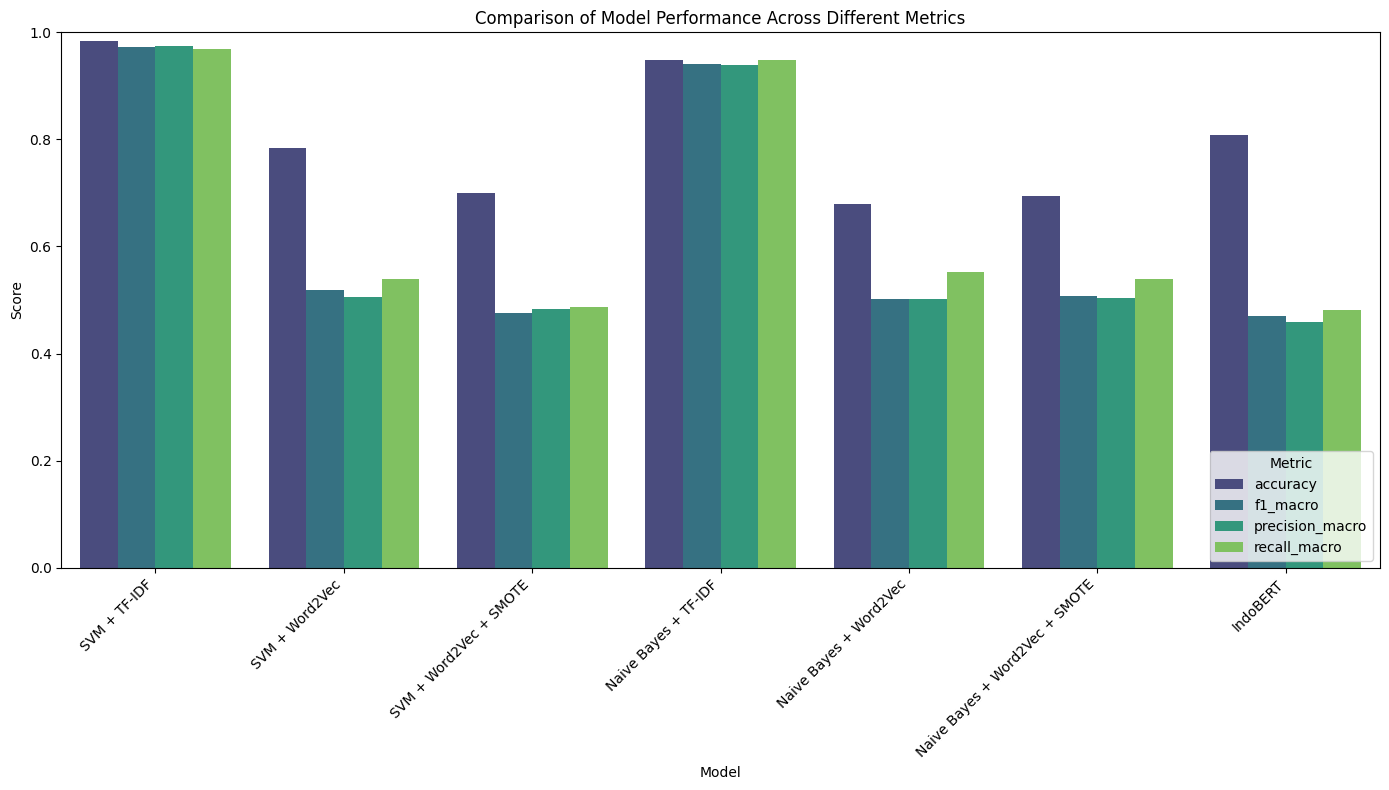

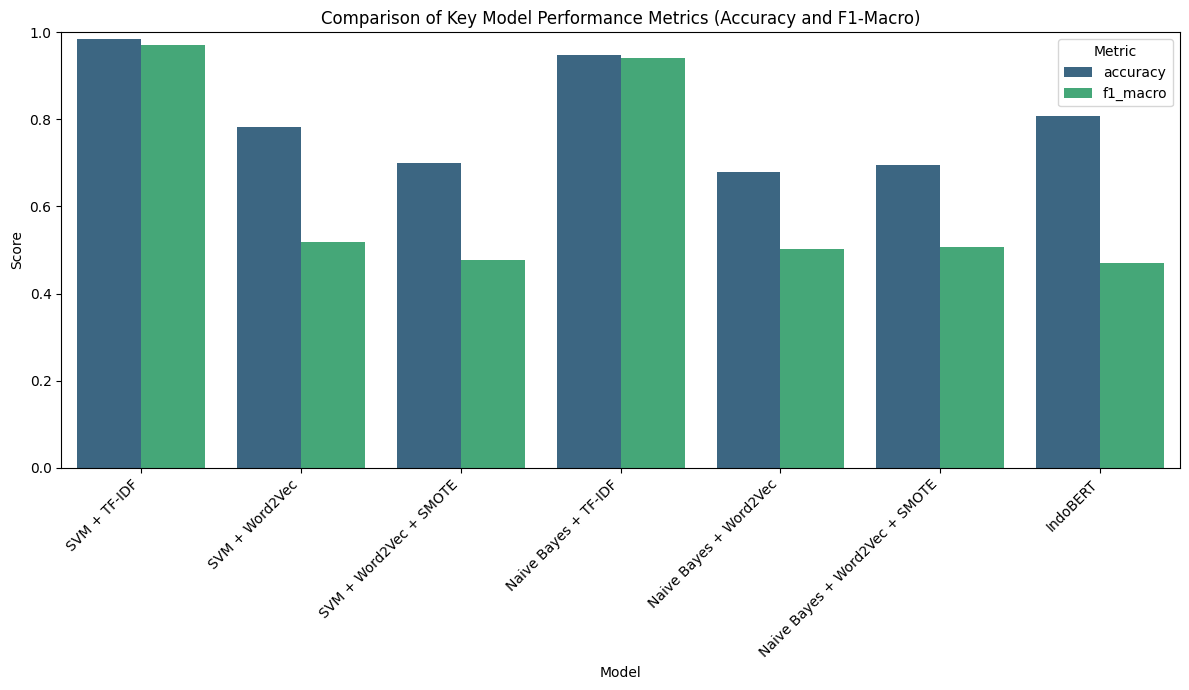

In [100]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset
import evaluate
from sklearn.naive_bayes import ComplementNB, GaussianNB
from imblearn.over_sampling import SMOTE

# --- Extract metrics from your model results ---

# SVM + TF-IDF (Using evaluation on full data from classification_report or cross-validation if available)
y_pred_svm_tfidf = grid.best_estimator_.predict(X) # Predict on the entire dataset (X)
acc_svm_tfidf = accuracy_score(y_encoded, y_pred_svm_tfidf) # Use y_encoded (full dataset true labels)
f1_svm_tfidf = f1_score(y_encoded, y_pred_svm_tfidf, average='macro')
precision_svm_tfidf = precision_score(y_encoded, y_pred_svm_tfidf, average='macro')
recall_svm_tfidf = recall_score(y_encoded, y_pred_svm_tfidf, average='macro')
results_svm_tfidf = {'accuracy': acc_svm_tfidf, 'f1_macro': f1_svm_tfidf, 'precision_macro': precision_svm_tfidf, 'recall_macro': recall_svm_tfidf}


# SVM + Word2Vec (Evaluation on Test Set)
acc_svm_w2v = accuracy_score(y_test_encoded, y_pred_w2v)
f1_svm_w2v = f1_score(y_test_encoded, y_pred_w2v, average='macro')
precision_svm_w2v = precision_score(y_test_encoded, y_pred_w2v, average='macro')
recall_svm_w2v = recall_score(y_test_encoded, y_pred_w2v, average='macro')
results_svm_w2v = {'accuracy': acc_svm_w2v, 'f1_macro': f1_svm_w2v, 'precision_macro': precision_svm_w2v, 'recall_macro': recall_svm_w2v}


# SVM + Word2Vec + SMOTE (Evaluation on Test Set)
acc_svm_w2v_smote = accuracy_score(y_test_encoded, y_pred_w2v_smote)
f1_svm_w2v_smote = f1_score(y_test_encoded, y_pred_w2v_smote, average='macro')
precision_svm_w2v_smote = precision_score(y_test_encoded, y_pred_w2v_smote, average='macro')
recall_svm_w2v_smote = recall_score(y_test_encoded, y_pred_w2v_smote, average='macro')
results_svm_w2v_smote = {'accuracy': acc_svm_w2v_smote, 'f1_macro': f1_svm_w2v_smote, 'precision_macro': precision_svm_w2v_smote, 'recall_macro': recall_svm_w2v_smote}

# Naive Bayes + TF-IDF (Evaluation on Full Data)
acc_nb_tfidf = accuracy_score(y_encoded, y_pred_nb)
f1_nb_tfidf = f1_score(y_encoded, y_pred_nb, average='macro')
precision_nb_tfidf = precision_score(y_encoded, y_pred_nb, average='macro')
recall_nb_tfidf = recall_score(y_encoded, y_pred_nb, average='macro')
results_nb_tfidf = {'accuracy': acc_nb_tfidf, 'f1_macro': f1_nb_tfidf, 'precision_macro': precision_nb_tfidf, 'recall_macro': recall_nb_tfidf}


# Naive Bayes + Word2Vec (Evaluation on Test Set)
acc_nb_w2v = accuracy_score(y_test_encoded, y_pred_nb_w2v)
f1_nb_w2v = f1_score(y_test_encoded, y_pred_nb_w2v, average='macro')
precision_nb_w2v = precision_score(y_test_encoded, y_pred_nb_w2v, average='macro')
recall_nb_w2v = recall_score(y_test_encoded, y_pred_nb_w2v, average='macro')
results_nb_w2v = {'accuracy': acc_nb_w2v, 'f1_macro': f1_nb_w2v, 'precision_macro': precision_nb_w2v, 'recall_macro': recall_nb_w2v}


# Naive Bayes + Word2Vec + SMOTE (Evaluation on Test Set)
acc_nb_w2v_smote = accuracy_score(y_test_encoded, y_pred_nb_w2v_smote)
f1_nb_w2v_smote = f1_score(y_test_encoded, y_pred_nb_w2v_smote, average='macro')
precision_nb_w2v_smote = precision_score(y_test_encoded, y_pred_nb_w2v_smote, average='macro')
recall_nb_w2v_smote = recall_score(y_test_encoded, y_pred_nb_w2v_smote, average='macro')
results_nb_w2v_smote = {'accuracy': acc_nb_w2v_smote, 'f1_macro': f1_nb_w2v_smote, 'precision_macro': precision_nb_w2v_smote, 'recall_macro': recall_nb_w2v_smote}

# IndoBERT (Evaluation from trainer.evaluate() and classification report on test set)
report_indobert = classification_report(y_test, y_pred_indobert, target_names=le.classes_, output_dict=True)
results_indobert = {
    'accuracy': report_indobert['accuracy'],
    'f1_macro': report_indobert['macro avg']['f1-score'],
    'precision_macro': report_indobert['macro avg']['precision'],
    'recall_macro': report_indobert['macro avg']['recall']
}


# Create a dictionary to store results
model_results = {
    'SVM + TF-IDF': results_svm_tfidf,
    'SVM + Word2Vec': results_svm_w2v,
    'SVM + Word2Vec + SMOTE': results_svm_w2v_smote,
    'Naive Bayes + TF-IDF': results_nb_tfidf,
    'Naive Bayes + Word2Vec': results_nb_w2v,
    'Naive Bayes + Word2Vec + SMOTE': results_nb_w2v_smote,
    'IndoBERT': results_indobert
}

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={'index': 'Model'})

print("\n--- Model Performance Comparison ---")
print(results_df)

# --- Visualization ---

# Melt DataFrame for easier plotting with seaborn
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting all metrics
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='viridis')
plt.title('Comparison of Model Performance Across Different Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1) # Scores are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()

# Plotting specific key metrics (e.g., Accuracy and F1-Macro)
key_metrics_df = results_df[['Model', 'accuracy', 'f1_macro']].melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=key_metrics_df, palette='viridis')
plt.title('Comparison of Key Model Performance Metrics (Accuracy and F1-Macro)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

### SVM vs Naive Bayes

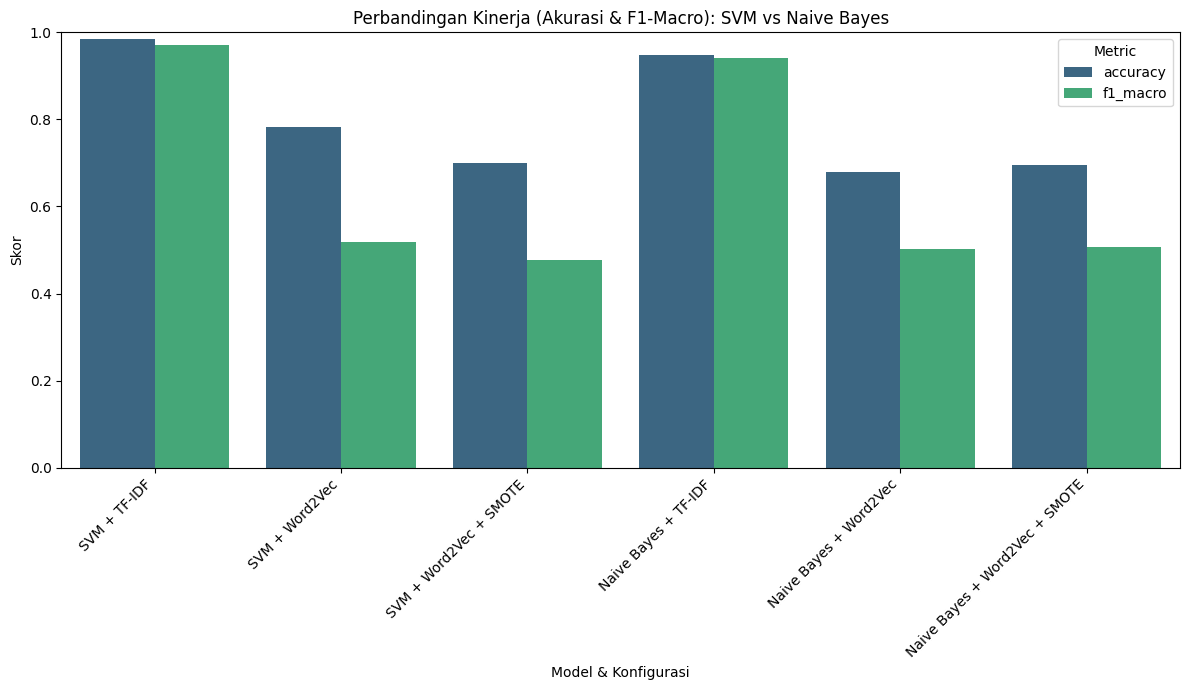

In [102]:
# Extract relevant results for SVM and Naive Bayes
svm_results = results_df[results_df['Model'].str.startswith('SVM')]
nb_results = results_df[results_df['Model'].str.startswith('Naive Bayes')]

# Combine the relevant results
comparison_df = pd.concat([svm_results, nb_results])

# Melt DataFrame for plotting
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting Accuracy
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Model', y='Score', data=comparison_melted[comparison_melted['Metric'] == 'accuracy'], palette='viridis')
# plt.title('Perbandingan Akurasi: SVM vs Naive Bayes (dengan Berbagai Feature Extraction & SMOTE)')
# plt.xlabel('Model')
# plt.ylabel('Akurasi')
# plt.ylim(0, 1)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # Plotting F1-Macro
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Model', y='Score', data=comparison_melted[comparison_melted['Metric'] == 'f1_macro'], palette='viridis')
# plt.title('Perbandingan F1-Macro: SVM vs Naive Bayes (dengan Berbagai Feature Extraction & SMOTE)')
# plt.xlabel('Model')
# plt.ylabel('F1-Macro Score')
# plt.ylim(0, 1)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Plotting side-by-side comparison for Accuracy and F1-Macro
comparison_key_metrics = comparison_df[['Model', 'accuracy', 'f1_macro']].melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_key_metrics, palette='viridis')
plt.title('Perbandingan Kinerja (Akurasi & F1-Macro): SVM vs Naive Bayes')
plt.xlabel('Model & Konfigurasi')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


### SVM vs IndoBERT

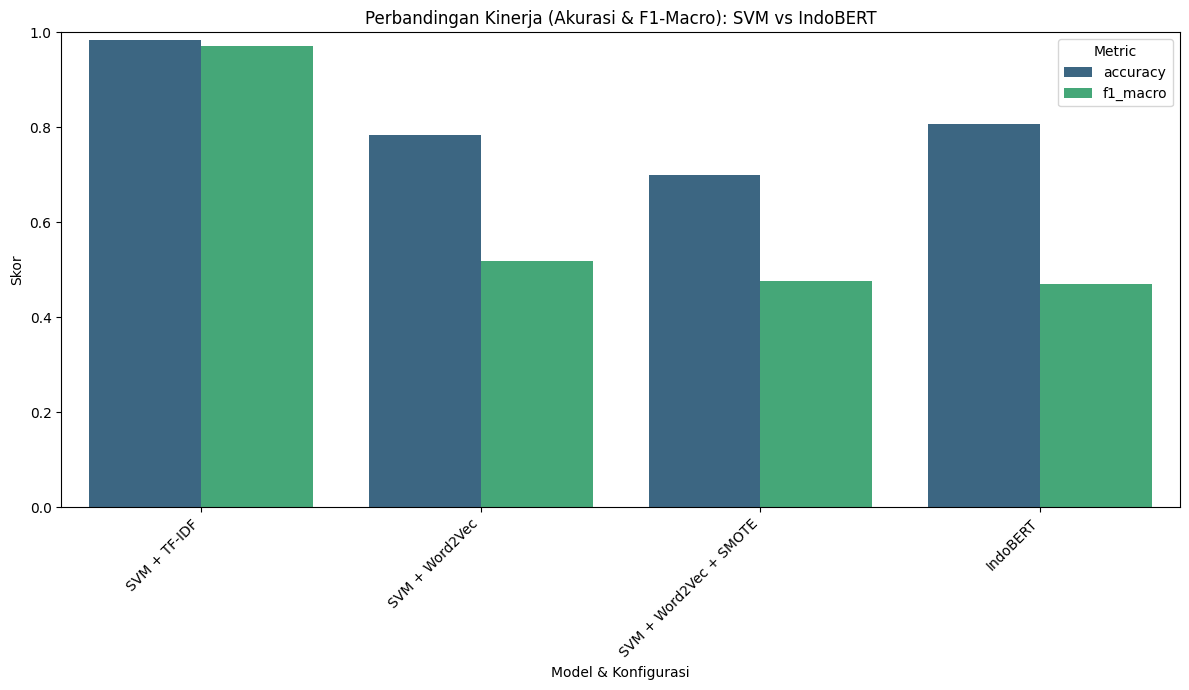

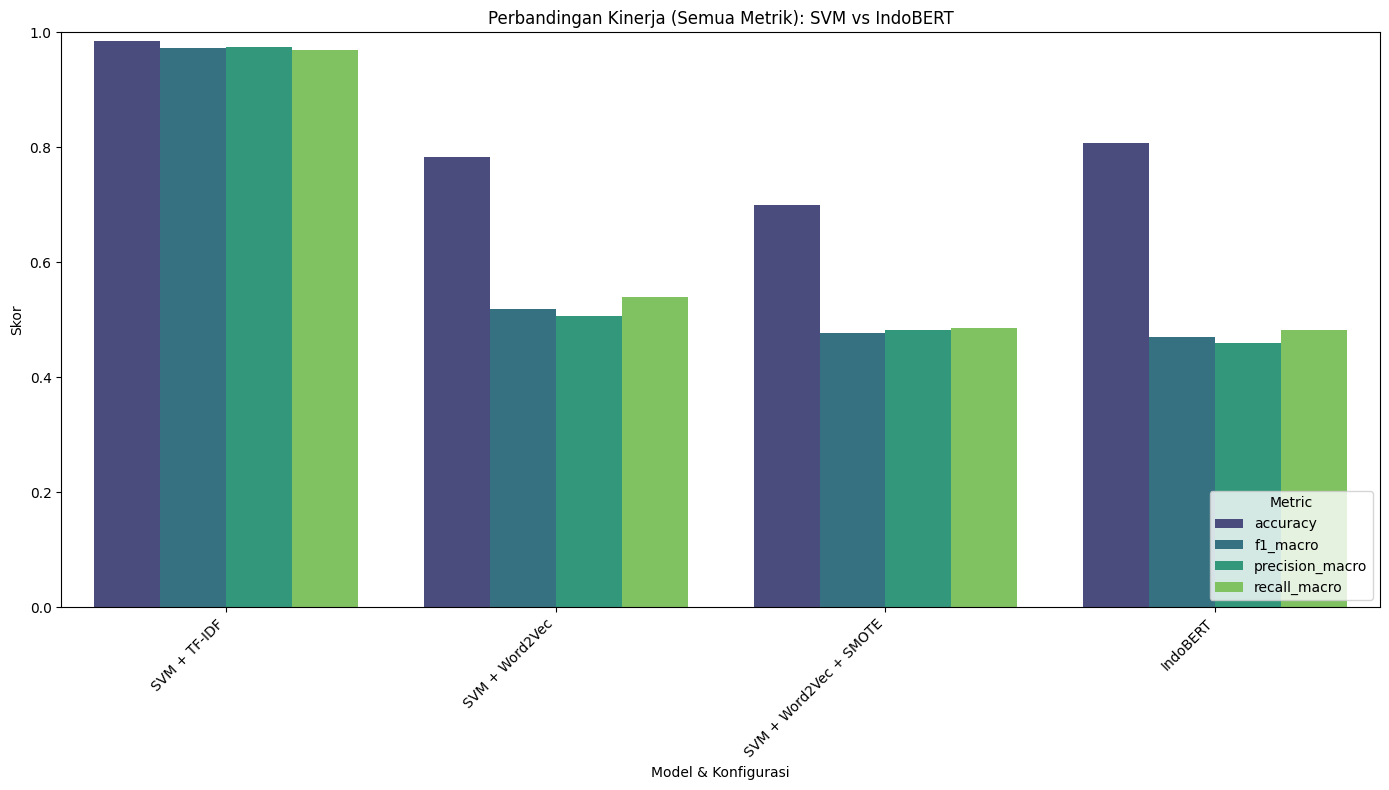

In [98]:
# Extract relevant results for SVM and IndoBERT
svm_results_for_comp = results_df[results_df['Model'].str.startswith('SVM')]
indobert_results_for_comp = results_df[results_df['Model'] == 'IndoBERT']

# Combine the relevant results
comparison_svm_indobert_df = pd.concat([svm_results_for_comp, indobert_results_for_comp])

# Melt DataFrame for plotting
comparison_svm_indobert_melted = comparison_svm_indobert_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting side-by-side comparison for Accuracy and F1-Macro
comparison_svm_indobert_key_metrics = comparison_svm_indobert_df[['Model', 'accuracy', 'f1_macro']].melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_svm_indobert_key_metrics, palette='viridis')
plt.title('Perbandingan Kinerja (Akurasi & F1-Macro): SVM vs IndoBERT')
plt.xlabel('Model & Konfigurasi')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Optional: Plotting all metrics if needed
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_svm_indobert_melted, palette='viridis')
plt.title('Perbandingan Kinerja (Semua Metrik): SVM vs IndoBERT')
plt.xlabel('Model & Konfigurasi')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()


### Naive Bayes vs IndoBERT

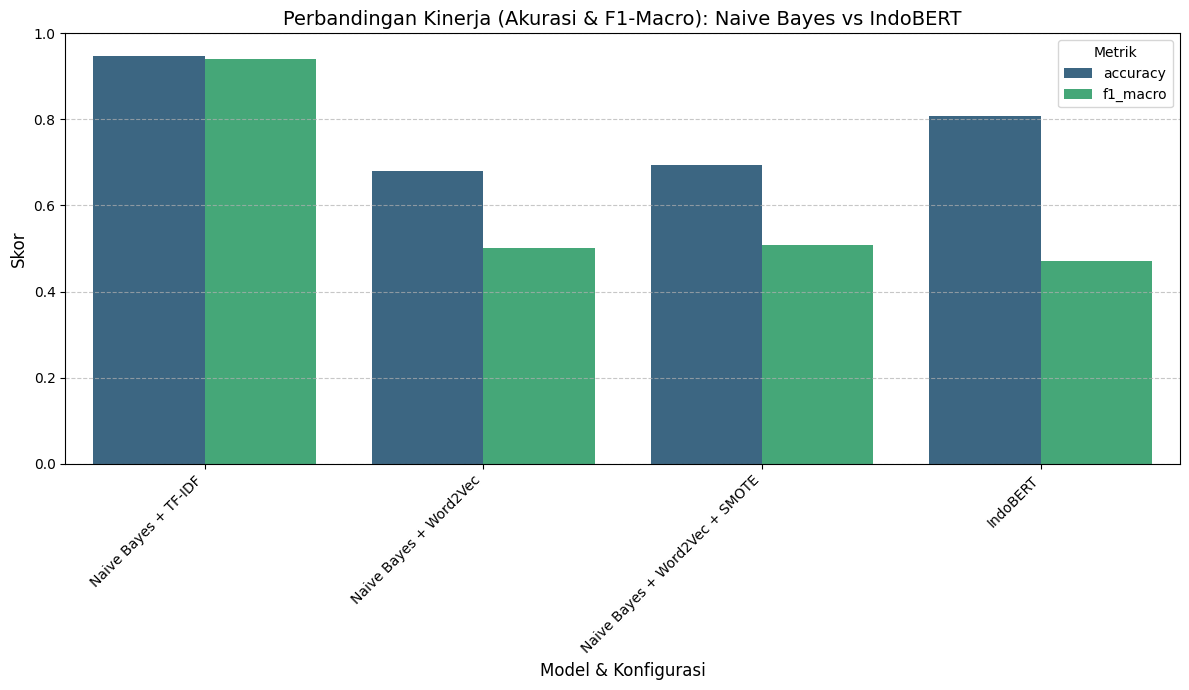

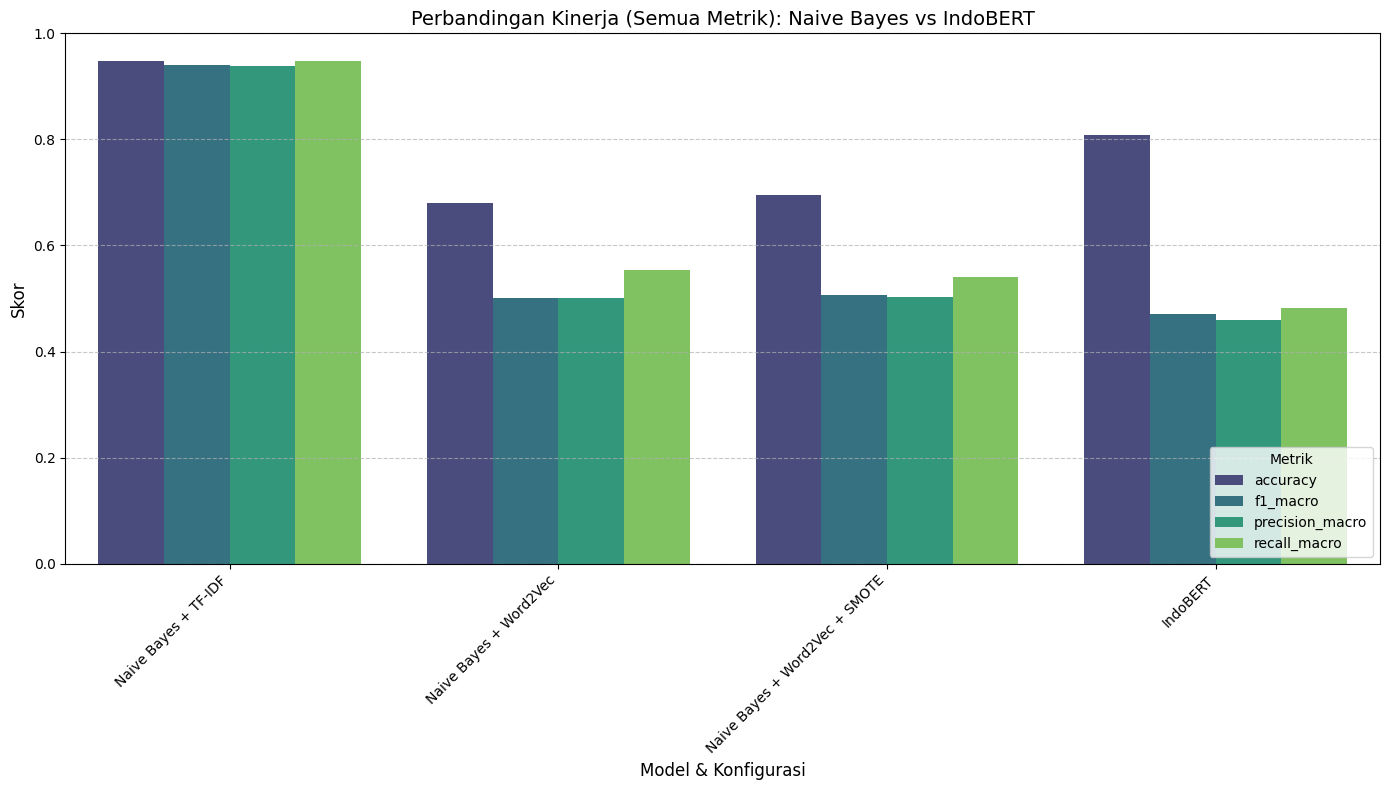

In [99]:
# Extract relevant results for Naive Bayes and IndoBERT
nb_results_for_comp = results_df[results_df['Model'].str.startswith('Naive Bayes')]
indobert_results_for_comp_nb = results_df[results_df['Model'] == 'IndoBERT'] # Reuse IndoBERT results

# Combine the relevant results
comparison_nb_indobert_df = pd.concat([nb_results_for_comp, indobert_results_for_comp_nb])

# Melt DataFrame for plotting
comparison_nb_indobert_melted = comparison_nb_indobert_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Define a green color palette
green_palette = sns.color_palette("Greens_d", n_colors=len(comparison_nb_indobert_key_metrics['Metric'].unique()))


# Plotting side-by-side comparison for Accuracy and F1-Macro with green tones
comparison_nb_indobert_key_metrics = comparison_nb_indobert_df[['Model', 'accuracy', 'f1_macro']].melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_nb_indobert_key_metrics, palette='viridis')
plt.title('Perbandingan Kinerja (Akurasi & F1-Macro): Naive Bayes vs IndoBERT', fontsize=14)
plt.xlabel('Model & Konfigurasi', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Metrik', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Plotting all metrics if needed with green tones
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_nb_indobert_melted, palette='viridis')
plt.title('Perbandingan Kinerja (Semua Metrik): Naive Bayes vs IndoBERT', fontsize=14)
plt.xlabel('Model & Konfigurasi', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Metrik', loc='lower right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Confusion Matrix


--- Confusion Matrix for IndoBERT on Test Set ---


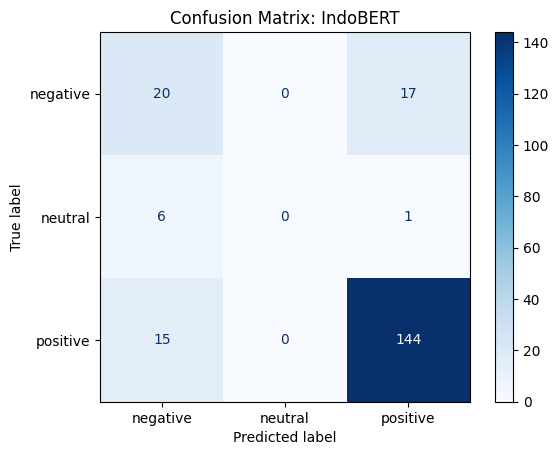


--- Confusion Matrix for SVM + TF-IDF on Full Data ---


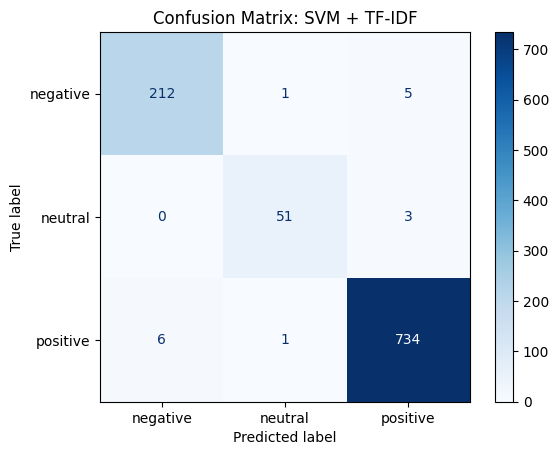


--- Confusion Matrix for SVM + Word2Vec on Test Set ---


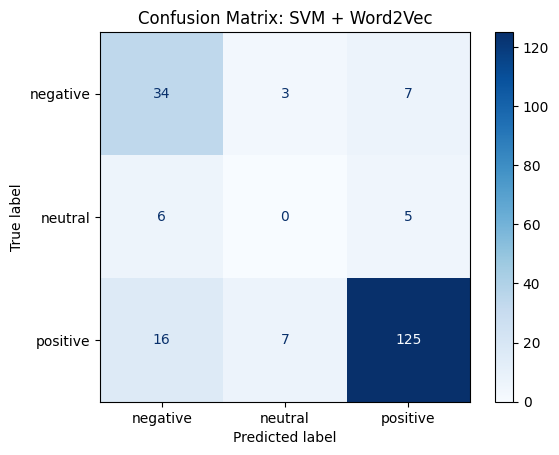


--- Confusion Matrix for SVM + Word2Vec + SMOTE on Test Set ---


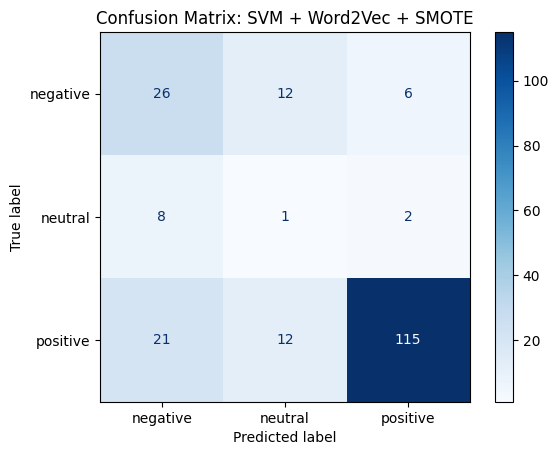


--- Confusion Matrix for Naive Bayes + TF-IDF on Full Data ---


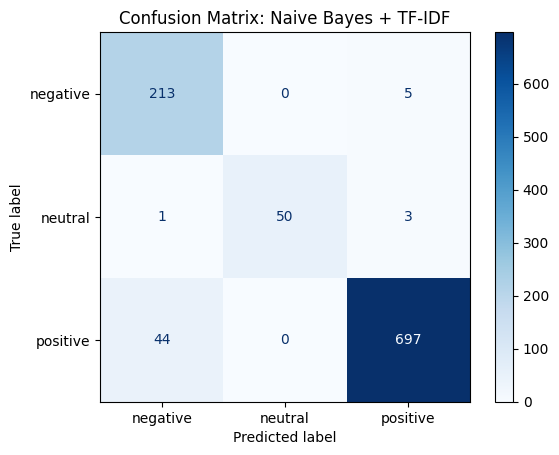


--- Confusion Matrix for Naive Bayes + Word2Vec on Test Set ---


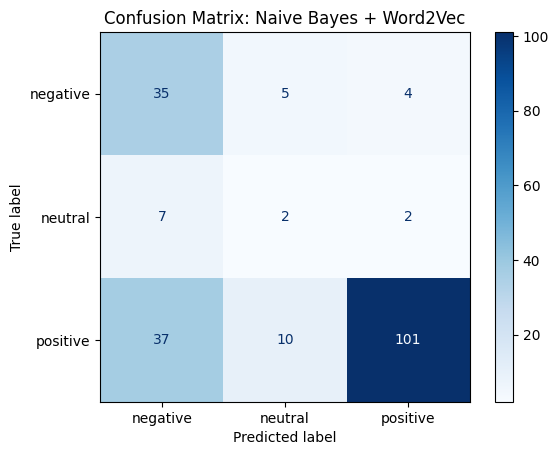


--- Confusion Matrix for Naive Bayes + Word2Vec + SMOTE on Test Set ---


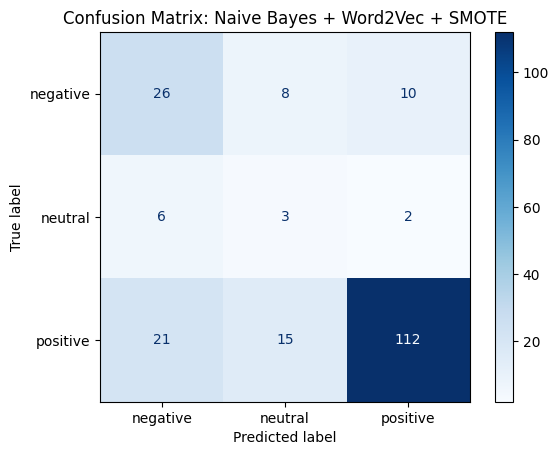

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay

# --- IndoBERT Confusion Matrix (Using Test Set) ---
# Ensure y_test and y_pred_indobert are accessible and from the IndoBERT section

# Calculate the confusion matrix
cm_indobert = confusion_matrix(y_test, y_pred_indobert, labels=le.classes_) # Use le.classes_ for labels

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_indobert, display_labels=le.classes_)

print("\n--- Confusion Matrix for IndoBERT on Test Set ---")
disp.plot(cmap=plt.cm.Blues) # Use a colormap like Blues
plt.title('Confusion Matrix: IndoBERT')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# --- SVM + TF-IDF Confusion Matrix (Using Full Data Evaluation) ---
# Ensure y_encoded and y_pred_svm_tfidf are accessible and from the SVM + TF-IDF section

# Calculate the confusion matrix
cm_svm_tfidf = confusion_matrix(y_encoded, y_pred_svm_tfidf, labels=le.transform(le.classes_)) # Need numerical labels here

# Get original class labels from the encoded labels
original_labels = le.inverse_transform(le.transform(le.classes_))


# Display the confusion matrix
disp_svm_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_svm_tfidf, display_labels=original_labels)

print("\n--- Confusion Matrix for SVM + TF-IDF on Full Data ---")
disp_svm_tfidf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SVM + TF-IDF')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# --- SVM + Word2Vec Confusion Matrix (Using Test Set) ---
# Ensure y_test_encoded and y_pred_w2v are accessible and from the SVM + Word2Vec section

# Calculate the confusion matrix
cm_svm_w2v = confusion_matrix(y_test_encoded, y_pred_w2v, labels=le.transform(le.classes_)) # Need numerical labels

# Display the confusion matrix
disp_svm_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_svm_w2v, display_labels=original_labels)

print("\n--- Confusion Matrix for SVM + Word2Vec on Test Set ---")
disp_svm_w2v.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SVM + Word2Vec')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# --- SVM + Word2Vec + SMOTE Confusion Matrix (Using Test Set) ---
# Ensure y_test_encoded and y_pred_w2v_smote are accessible and from the SVM + Word2Vec + SMOTE section

# Calculate the confusion matrix
cm_svm_w2v_smote = confusion_matrix(y_test_encoded, y_pred_w2v_smote, labels=le.transform(le.classes_)) # Need numerical labels

# Display the confusion matrix
disp_svm_w2v_smote = ConfusionMatrixDisplay(confusion_matrix=cm_svm_w2v_smote, display_labels=original_labels)

print("\n--- Confusion Matrix for SVM + Word2Vec + SMOTE on Test Set ---")
disp_svm_w2v_smote.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SVM + Word2Vec + SMOTE')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


# --- Naive Bayes + TF-IDF Confusion Matrix (Using Full Data Evaluation) ---
# Ensure y_encoded and y_pred_nb are accessible and from the Naive Bayes + TF-IDF section

# Calculate the confusion matrix
cm_nb_tfidf = confusion_matrix(y_encoded, y_pred_nb, labels=le.transform(le.classes_)) # Need numerical labels

# Display the confusion matrix
disp_nb_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_nb_tfidf, display_labels=original_labels)

print("\n--- Confusion Matrix for Naive Bayes + TF-IDF on Full Data ---")
disp_nb_tfidf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Naive Bayes + TF-IDF')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


# --- Naive Bayes + Word2Vec Confusion Matrix (Using Test Set) ---
# Ensure y_test_encoded and y_pred_nb_w2v are accessible and from the Naive Bayes + Word2Vec section

# Calculate the confusion matrix
cm_nb_w2v = confusion_matrix(y_test_encoded, y_pred_nb_w2v, labels=le.transform(le.classes_)) # Need numerical labels

# Display the confusion matrix
disp_nb_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_nb_w2v, display_labels=original_labels)

print("\n--- Confusion Matrix for Naive Bayes + Word2Vec on Test Set ---")
disp_nb_w2v.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Naive Bayes + Word2Vec')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# --- Naive Bayes + Word2Vec + SMOTE Confusion Matrix (Using Test Set) ---
# Ensure y_test_encoded and y_pred_nb_w2v_smote are accessible and from the Naive Bayes + Word2Vec + SMOTE section

# Calculate the confusion matrix
cm_nb_w2v_smote = confusion_matrix(y_test_encoded, y_pred_nb_w2v_smote, labels=le.transform(le.classes_)) # Need numerical labels

# Display the confusion matrix
disp_nb_w2v_smote = ConfusionMatrixDisplay(confusion_matrix=cm_nb_w2v_smote, display_labels=original_labels)

print("\n--- Confusion Matrix for Naive Bayes + Word2Vec + SMOTE on Test Set ---")
disp_nb_w2v_smote.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Naive Bayes + Word2Vec + SMOTE')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### ROC AUC

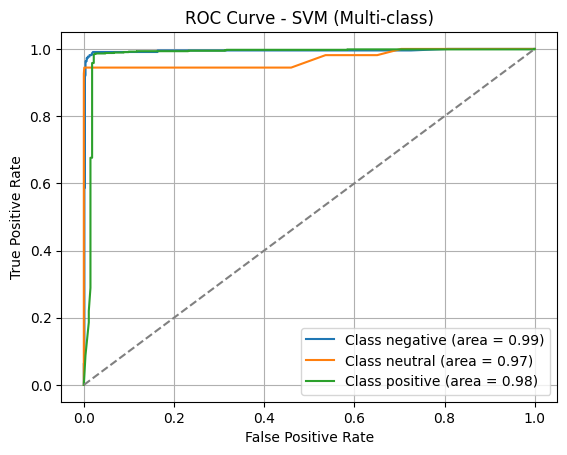

In [134]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Only works if you use binary or have access to decision_function
y_scores = grid.best_estimator_.decision_function(X)

if len(le.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_encoded, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend()
    plt.grid()
    plt.show()
else:
    y_bin = label_binarize(y_encoded, classes=range(len(le.classes_)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM (Multi-class)')
    plt.legend()
    plt.grid()
    plt.show()


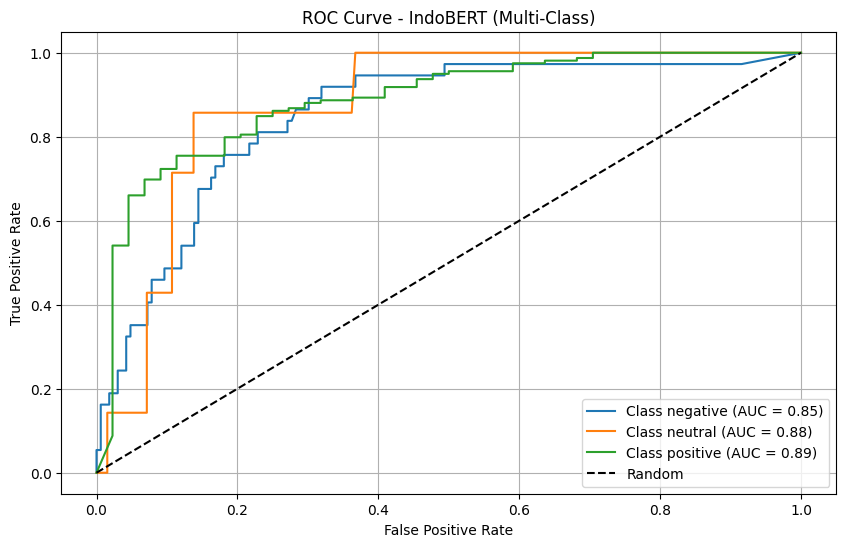

In [133]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Softmax untuk ambil probabilitas prediksi
from scipy.special import softmax
probs = softmax(predictions.predictions, axis=1)

# Binarisasi label untuk ROC
y_test_bin = label_binarize(le.transform(y_test), classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - IndoBERT (Multi-Class)')
plt.legend()
plt.grid()
plt.show()

## Save Model

SVM

In [116]:
import joblib

In [117]:
# Save the best SVM TF-IDF model
joblib.dump(grid.best_estimator_, 'svm_tfidf_model.pkl')
print("SVM TF-IDF model saved as svm_tfidf_model.pkl")

# Save the best SVM Word2Vec model
joblib.dump(grid_w2v.best_estimator_, 'svm_w2v_model.pkl')
print("SVM Word2Vec model saved as svm_w2v_model.pkl")

# Save the best SVM Word2Vec + SMOTE model
joblib.dump(grid_w2v_smote.best_estimator_, 'svm_w2v_smote_model.pkl')
print("SVM Word2Vec + SMOTE model saved as svm_w2v_smote_model.pkl")

# Naive Bayes
# Save the best Naive Bayes TF-IDF model
joblib.dump(grid_nb.best_estimator_, 'nb_tfidf_model.pkl')
print("Naive Bayes TF-IDF model saved as nb_tfidf_model.pkl")

# Save the best Naive Bayes Word2Vec model
joblib.dump(grid_nb_w2v.best_estimator_, 'nb_w2v_model.pkl')
print("Naive Bayes Word2Vec model saved as nb_w2v_model.pkl")

# Save the best Naive Bayes Word2Vec + SMOTE model
# Use the model object, not the GridSearchCV object
joblib.dump(nb_w2v_smote_model, 'nb_w2v_smote_model.pkl')
print("Naive Bayes Word2Vec + SMOTE model saved as nb_w2v_smote_model.pkl")

# IndoBERT
# Save the trained IndoBERT model and tokenizer
trainer.save_model('./indobert_sentiment_model')
print("IndoBERT model saved to ./indobert_sentiment_model directory")

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')
print("Label encoder saved as label_encoder.pkl")

# Save the Word2Vec model
w2v_model.save("word2vec_model.w2v")
print("Word2Vec model saved as word2vec_model.w2v")

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")


SVM TF-IDF model saved as svm_tfidf_model.pkl
SVM Word2Vec model saved as svm_w2v_model.pkl
SVM Word2Vec + SMOTE model saved as svm_w2v_smote_model.pkl
Naive Bayes TF-IDF model saved as nb_tfidf_model.pkl
Naive Bayes Word2Vec model saved as nb_w2v_model.pkl
Naive Bayes Word2Vec + SMOTE model saved as nb_w2v_smote_model.pkl
IndoBERT model saved to ./indobert_sentiment_model directory
Label encoder saved as label_encoder.pkl
Word2Vec model saved as word2vec_model.w2v
TF-IDF vectorizer saved as tfidf_vectorizer.pkl
